In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from numpy.random import seed
import tensorflow as tf
%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (12,8)})

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = pd.concat([train, test], axis=0, sort=True)

In [7]:
df.head

<bound method NDFrame.head of       Age Cabin Embarked      Fare  \
0    22.0   NaN        S    7.2500   
1    38.0   C85        C   71.2833   
2    26.0   NaN        S    7.9250   
3    35.0  C123        S   53.1000   
4    35.0   NaN        S    8.0500   
..    ...   ...      ...       ...   
413   NaN   NaN        S    8.0500   
414  39.0  C105        C  108.9000   
415  38.5   NaN        S    7.2500   
416   NaN   NaN        S    8.0500   
417   NaN   NaN        C   22.3583   

                                                  Name  Parch  PassengerId  \
0                              Braund, Mr. Owen Harris      0            1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                               Heikkinen, Miss. Laina      0            3   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                             Allen, Mr. William Henry      0            5   
..                                           

In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1046,NaN,NaN,NaN,29.8811,14.4135,0.17,21,28,39,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1307,3,S,914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1308,NaN,NaN,NaN,33.2955,51.7587,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Kelly, Mr. James",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SibSp,1309,NaN,NaN,NaN,0.498854,1.04166,0,0,0,1,8


In [9]:
df['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

In [10]:
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

In [14]:
df['Title'].value_counts()

Mr        767
Miss      264
Mrs       201
Master     61
Dr          8
Rev         8
Name: Title, dtype: int64

In [13]:
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'Title': mapping}, inplace=True)

In [15]:
title_ages = dict(df.groupby('Title')['Age'].median())

In [16]:
df['age_med'] = df['Title'].apply(lambda x: title_ages[x])

In [17]:
df['Age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

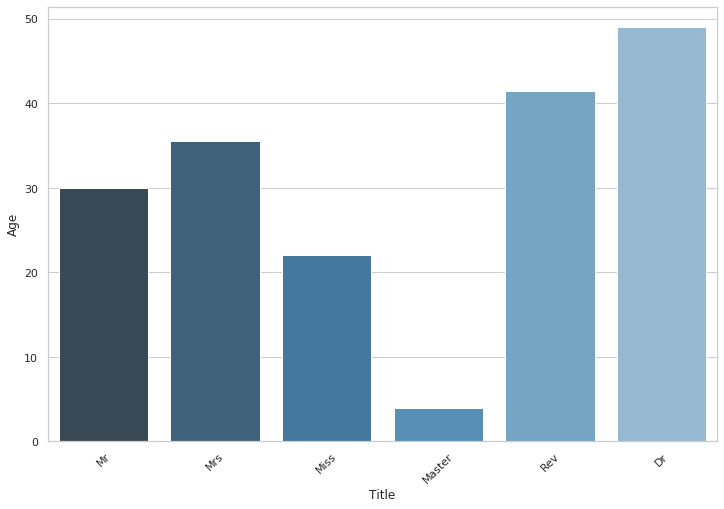

In [18]:
sns.barplot(x='Title', y='Age', data=df, estimator=np.median, ci=None, palette='Blues_d')
plt.xticks(rotation=45)
plt.show()

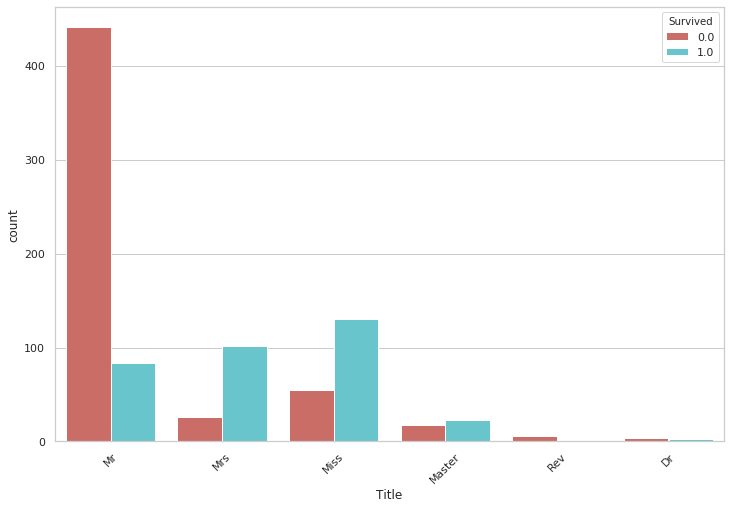

In [20]:
sns.countplot(x='Title', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

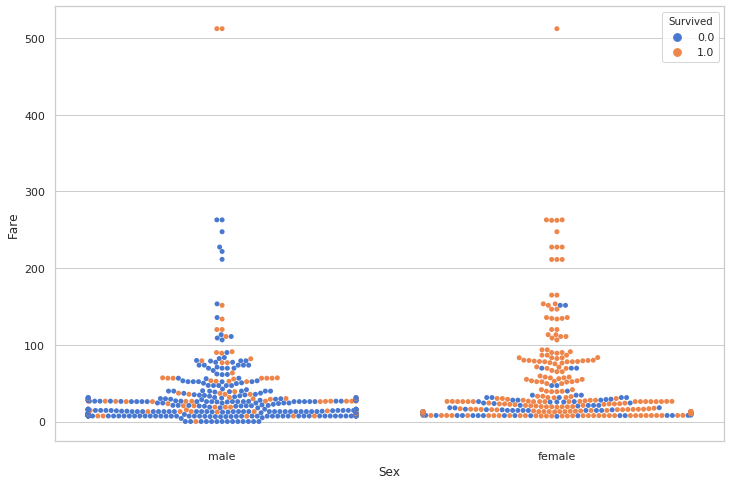

In [25]:
sns.swarmplot(x='Sex', y='Fare', hue='Survived', data=df)
plt.show()

In [22]:
class_fares = dict(df.groupby('Pclass')['Fare'].median())

In [23]:
df['fare_med'] = df['Pclass'].apply(lambda x: class_fares[x])

In [24]:
df['Fare'].fillna(df['fare_med'], inplace=True, )
del df['fare_med']

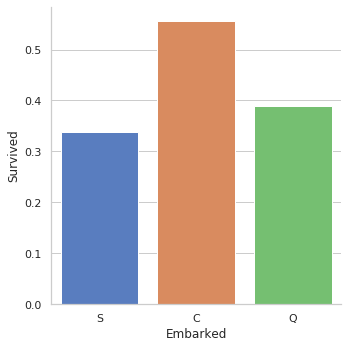

In [28]:
sns.catplot(x='Embarked', y='Survived', data=df,
            kind='bar', palette='muted', ci=None)
plt.show()

In [27]:
df['Embarked'].fillna(method='backfill', inplace=True)

In [29]:
df['Family_Size'] = df['Parch'] + df['SibSp']

In [30]:
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309,NaN,NaN,NaN,29.5624,13.1654,0.17,22,30,35.5,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1309,NaN,NaN,NaN,33.2762,51.7436,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Kelly, Mr. James",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SibSp,1309,NaN,NaN,NaN,0.498854,1.04166,0,0,0,1,8


In [31]:
train = df[pd.notnull(df['Survived'])]
test = df[pd.isnull(df['Survived'])]

In [32]:
train.to_csv('train_clean.csv', index=False)
test.to_csv('test_clean.csv', index=False)

In [33]:
train = pd.read_csv('train_clean.csv', )
test = pd.read_csv('test_clean.csv')
df = pd.concat([train, test], axis=0, sort=True)

In [35]:
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,30.0,NaN,S,0,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,Mr
414,39.0,C105,C,0,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,Mrs
415,38.5,NaN,S,0,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,Mr
416,30.0,NaN,S,0,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,Mr


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309,NaN,NaN,NaN,29.5624,13.1654,0.17,22,30,35.5,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Family_Size,1309,NaN,NaN,NaN,0.883881,1.58364,0,0,0,1,10
Fare,1309,NaN,NaN,NaN,33.2762,51.7436,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Kelly, Mr. James",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN


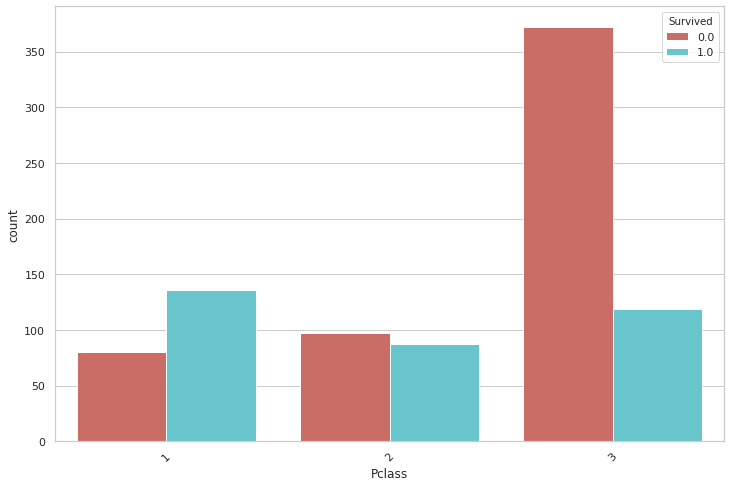

In [37]:
sns.countplot(x='Pclass', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

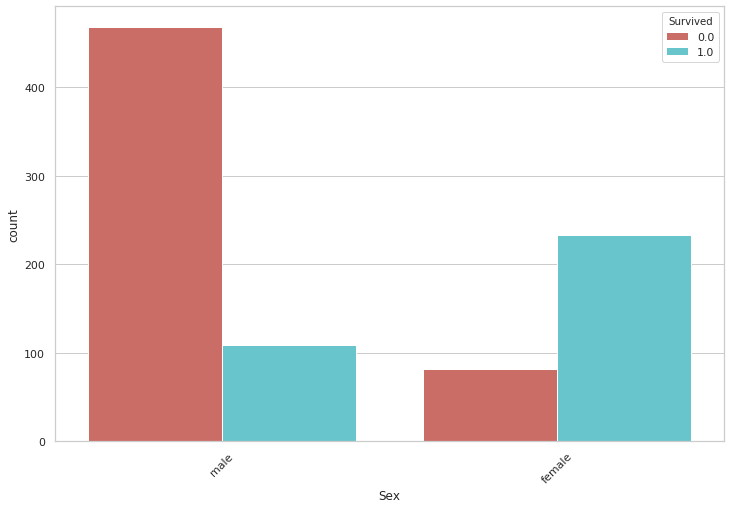

In [38]:
sns.countplot(x='Sex', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

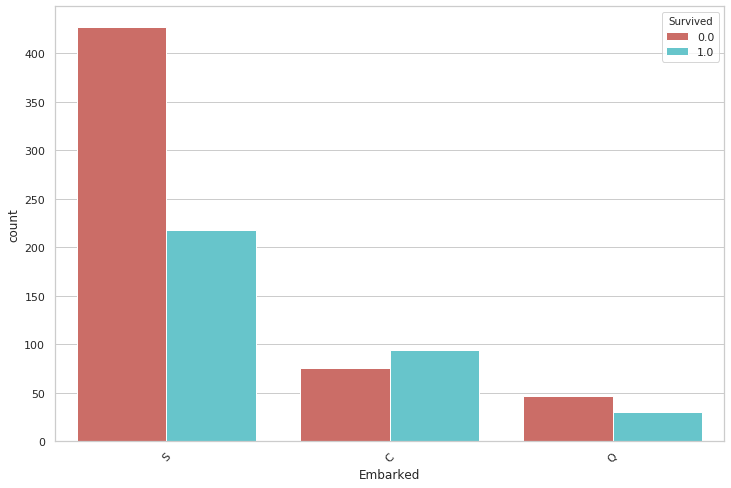

In [39]:
sns.countplot(x='Embarked', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [40]:
df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].cat.codes

In [41]:
categorical = ['Embarked', 'Title']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [42]:
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [43]:
df.head()

,Age,Family_Size,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,22.0,1,7.2500,0,3,1,1,0.0,0,0,1,0,0,0,1,0,0
1,38.0,1,71.2833,0,1,0,1,1.0,1,0,0,0,0,0,0,1,0
2,26.0,0,7.9250,0,3,0,0,1.0,0,0,1,0,0,1,0,0,0
3,35.0,1,53.1000,0,1,0,1,1.0,0,0,1,0,0,0,0,1,0
4,35.0,0,8.0500,0,3,1,0,0.0,0,0,1,0,0,0,1,0,0


In [44]:
continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))

In [46]:
display_all(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
Age,1309.0,1.692899e-16,1.000382,-2.233408,-0.574635,0.033252,0.451175,3.832549
Family_Size,1309.0,2.593630e-16,1.000382,-0.558346,-0.558346,-0.558346,0.073352,5.758637
Fare,1309.0,-6.473474e-17,1.000382,-0.643344,-0.490691,-0.363894,-0.038690,9.261749
Parch,1309.0,-8.549311e-17,1.000382,-0.445000,-0.445000,-0.445000,-0.445000,9.956864
Pclass,1309.0,-1.399441e-16,1.000382,-1.546098,-0.352091,0.841916,0.841916,0.841916
Sex,1309.0,6.440031e-01,0.478997,0.000000,0.000000,1.000000,1.000000,1.000000
SibSp,1309.0,-6.632925e-16,1.000382,-0.479087,-0.479087,-0.479087,0.481288,7.203909
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Embarked_C,1309.0,2.070283e-01,0.405331,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,1309.0,9.396486e-02,0.291891,0.000000,0.000000,0.000000,0.000000,1.000000


In [87]:
X_train = df[pd.notnull(df['Survived'])].drop(['Survived'], axis=1)
y_train = df[pd.notnull(df['Survived'])]['Survived']
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

In [112]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
        
    model.add(Dropout(dr))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics=['accuracy'])
    
    return model

In [113]:
model = create_model()

In [114]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
None


In [115]:
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [116]:
val_acc = np.mean(training.history['val_accuracy'])

In [117]:
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 86.85%


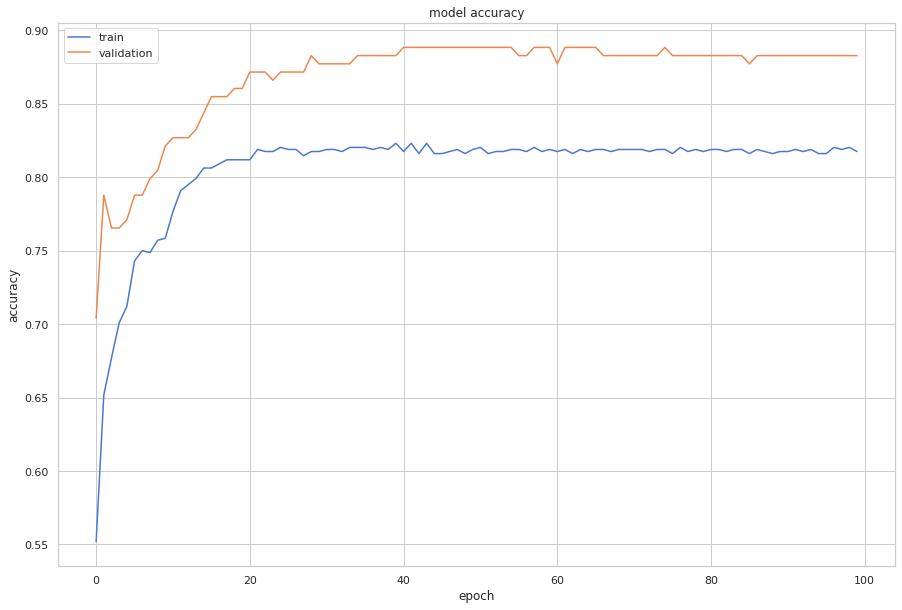


val_acc: 86.85%


In [118]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))